/tmp/ipykernel_2457886/1446977961.py:12: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  transactions = pd.read_csv("transactions_aggregated.csv")
/tmp/ipykernel_2457886/1446977961.py:13: DtypeWarning: Columns (1,4,10,13,16,18,19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  validators = pd.read_csv("validators_aggregated.csv")
/tmp/ipykernel_2457886/1446977961.py:66: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged['lag_close_1'] = merged['close'].shift(1).fillna(method='bfill')
/tmp/ipykernel_2457886/1446977961.py:67: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged['lag_close_2'] = merged['close'].shift(2).fillna(method='bfill')


Classification Report:
               precision    recall  f1-score   support

        High       0.98      0.92      0.95       118
         Low       0.98      0.96      0.97        92
      Medium       0.89      0.96      0.93       113

    accuracy                           0.95       323
   macro avg       0.95      0.95      0.95       323
weighted avg       0.95      0.95      0.95       323

Confusion Matrix:
 [[109   0   9]
 [  0  88   4]
 [  2   2 109]]


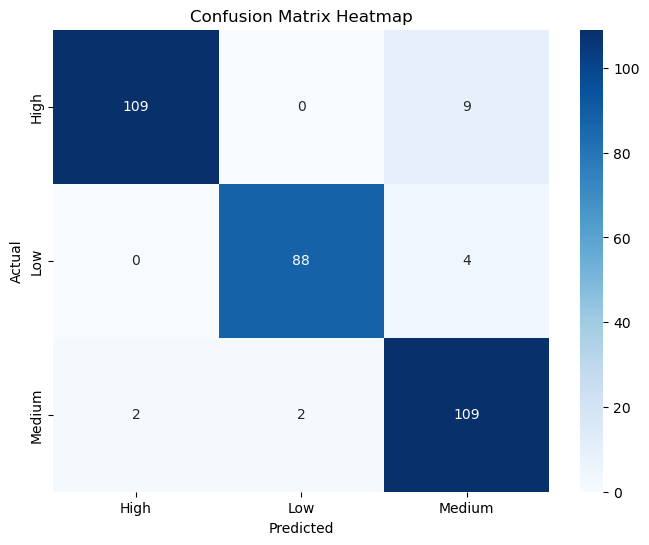

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor


In [9]:

# 1. Load datasets
eth_price = pd.read_csv("data/ETH_USD_11_20_2020-1_19_2021_historical_prices.csv", sep=";")
transactions = pd.read_csv("data/transactions_aggregated_21_22.csv")
validators = pd.read_csv("data/validators_aggregated_21_22.csv")

# 2. Clean and preprocess ETH price data
eth_price['datetime'] = pd.to_datetime(eth_price['timestamp'], errors='coerce')
eth_price = eth_price[['datetime', 'close']].dropna()
eth_price['close'] = pd.to_numeric(eth_price['close'], errors='coerce')
eth_price.dropna(inplace=True)
eth_price['date'] = eth_price['datetime'].dt.date

# 3. Preprocess transactions
transactions['datetime'] = pd.to_datetime(transactions['datetime'], errors='coerce')
transactions['valueETH'] = pd.to_numeric(transactions['valueETH'], errors='coerce')
transactions['gasUsed'] = pd.to_numeric(transactions['gasUsed'], errors='coerce')
transactions = transactions.dropna(subset=['datetime', 'valueETH', 'gasUsed'])

# Aggregate transactions by day
tx_daily = transactions.groupby(transactions['datetime'].dt.date).agg({
    'valueETH': 'sum',
    'gas': 'mean'
}).reset_index().rename(columns={'datetime': 'date'})

# 4. Preprocess validators
validators['datetime'] = pd.to_datetime(validators['datetime'], errors='coerce')
validators['valueETH'] = pd.to_numeric(validators['valueETH'], errors='coerce')
validators['gasUsed'] = pd.to_numeric(validators['gasUsed'], errors='coerce')
validators = validators.dropna(subset=['datetime', 'valueETH', 'gasUsed'])

# Aggregate validator data by day
validators_daily = validators.groupby(validators['datetime'].dt.date).agg({
    'valueETH': 'sum',
    'gas': 'mean'
}).reset_index().rename(columns={'datetime': 'date'})
validators_daily.columns = ['date', 'validator_valueETH', 'validator_gasUsed']

# 5. Merge datasets
merged = eth_price.merge(tx_daily, on='date', how='left')
merged = merged.merge(val_daily, on='date', how='left')
merged.fillna(0, inplace=True)

# 6. Feature engineering
merged['daily_return'] = merged['close'].pct_change().fillna(0)
merged['lag_return_1'] = merged['daily_return'].shift(1).fillna(0)
merged['lag_return_2'] = merged['daily_return'].shift(2).fillna(0)
merged['rolling_vol_3'] = merged['daily_return'].rolling(window=3).std().fillna(0)
merged['rolling_vol_7'] = merged['daily_return'].rolling(window=7).std().fillna(0)
merged['momentum'] = merged['close'] - merged['close'].shift(3).fillna(method='bfill')
merged['rolling_mean'] = merged['close'].rolling(window=3).mean().fillna(method='bfill')

# 7. New Labeling strategy based on daily price change (not absolute price)
merged['price_change'] = merged['close'].pct_change().fillna(0)

# Define the thresholds for high, medium, and low labels based on daily returns
def label_price_change(change):
    if change > 0.02:  # Strong positive return
        return 'High'
    elif change < -0.01:  # Negative return
        return 'Low'
    else:  # Neutral or minimal change
        return 'Medium'
    else:
        return 'High'
merged['price_label'] = merged['close'].apply(classify_price)

# 7. Add lag features (important temporal context)
merged['lag_close_1'] = merged['close'].shift(1).fillna(method='bfill')
merged['lag_close_2'] = merged['close'].shift(2).fillna(method='bfill')

# 8. Prepare features and labels
features = merged[['valueETH', 'gasUsed', 'validator_valueETH', 'validator_gasUsed', 'lag_close_1', 'lag_close_2']]
labels = merged['price_label']

features = features[labels.notna()]
labels = labels[labels.notna()]

# 9. Encode labels
le = LabelEncoder()
y = le.fit_transform(labels)
X = features.copy()

# 10. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 11. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.05, stratify=y, random_state=42
)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

# 10. Train optimized Random Forest
clf = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)

# 11. Evaluate model
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
